In [2]:
import mujoco
import mujoco.viewer
import mediapy as media
import time

In [3]:
# PATHS
HR_MODEL_PATH = "stretch2//stretch.xml"
hr_model = mujoco.MjModel.from_xml_path(HR_MODEL_PATH)


In [4]:

# Load and create renderer
hr_data = mujoco.MjData(hr_model)
hr_renderer = mujoco.Renderer(hr_model)

# Dynamics
mujoco.mj_forward(hr_model, hr_data)
hr_renderer.update_scene(hr_data)
#media.show_image(hr_renderer.render()) # Show image

# Simulation
duration = 3
fps = 60
frames = []
camera_frames = []

# HR controls
mujoco.mj_resetData(hr_model, hr_data)
hr_data.ctrl[0] = 5
hr_data.ctrl[7] = -2
hr_data.ctrl[6] = 1

# Run simulation
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
for i in range(duration*fps):
	while hr_data.time < i/fps:
		# Render simulation
		mujoco.mj_step(hr_model, hr_data)
	hr_renderer.update_scene(hr_data, camera='camera_depth')
	cam_pixels = hr_renderer.render()
	if i == 5:
		print(len(cam_pixels[0]))
		print(cam_pixels)
	camera_frames.append(cam_pixels)

# Show simulation
media.show_video(camera_frames, fps=fps)


320
[[[20 30 41]
  [21 31 42]
  [21 31 42]
  ...
  [21 31 41]
  [21 31 41]
  [21 31 41]]

 [[21 31 42]
  [21 31 42]
  [21 31 42]
  ...
  [21 31 41]
  [21 31 41]
  [21 31 41]]

 [[21 31 42]
  [21 31 42]
  [21 31 42]
  ...
  [21 31 41]
  [21 31 41]
  [21 31 41]]

 ...

 [[10 21 31]
  [10 21 31]
  [10 21 31]
  ...
  [10 21 31]
  [10 21 31]
  [10 21 31]]

 [[10 21 31]
  [10 21 31]
  [10 21 31]
  ...
  [10 21 31]
  [10 21 31]
  [10 21 31]]

 [[10 21 31]
  [10 21 31]
  [10 21 31]
  ...
  [10 21 31]
  [10 21 31]
  [10 21 31]]]


""

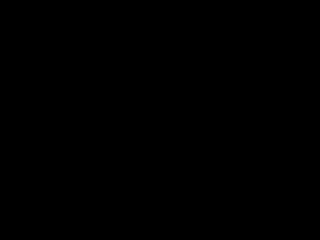

In [6]:
# Stretch 3 Stuff that Ken is working on
HR_URDF_PATH = 'stretch3/stretch.xml'
hr_model = mujoco.MjModel.from_xml_path(HR_URDF_PATH)
hr_data = mujoco.MjData(hr_model)
hr_renderer = mujoco.Renderer(hr_model)
mujoco.mj_forward(hr_model, hr_data)
hr_renderer.update_scene(hr_data)
media.show_image(hr_renderer.render())
duration = 3
fps = 60
frames = []
camera_frames = []

mujoco.mj_resetData(hr_model, hr_data)
# hr_data.ctrl[0] = 10
# hr_data.ctrl[7] = -2
# hr_data.ctrl[6] = 1
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
while hr_data.time < duration:
	mujoco.mj_step(hr_model, hr_data)
	if len(frames) < hr_data.time * fps:
		hr_renderer.update_scene(hr_data)
		cam_pixels = hr_renderer.render()
		camera_frames.append(cam_pixels)
media.show_video(camera_frames, fps=fps)


In [7]:
m = mujoco.MjModel.from_xml_path(HR_MODEL_PATH)
d = mujoco.MjData(m)

r = mujoco.Renderer(m)

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
fps = 60
camera_frames = []

with mujoco.viewer.launch_passive(m, d) as viewer:
  # Close the viewer automatically after 30 wall-seconds.
  start = time.time()
  mujoco.mj_resetData(m, d)

  d.ctrl[0] = 5
  d.ctrl[1]= 5
  d.ctrl[7] = -2
  d.ctrl[6] = 1

  i = 0

  while viewer.is_running() and time.time() - start < 5:
    step_start = time.time()

    # mj_step can be replaced with code that also evaluates
    # a policy and applies a control signal before stepping the physics.
    mujoco.mj_step(m, d)

    # Example modification of a viewer option: toggle contact points every two seconds.
    with viewer.lock():
      viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(d.time % 2)

    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()

    
    if time.time() - start > i / fps:
      i += 1
      r.update_scene(d, camera='camera_rgb')
      cam_pixels = r.render()
      camera_frames.append(cam_pixels)
    
    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = m.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

media.show_video(camera_frames, fps=fps)


In [1]:
from src.simulator import Simulator
HR_MODEL_PATH = "stretch3/stretch.xml"
sim = Simulator(HR_MODEL_PATH)
sim.run_sim(camera=None)
